<a href="https://colab.research.google.com/github/kthanikonda/Privacy-Aware-Computing/blob/main/1p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import re
import numpy as np
import nltk
import spacy
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from transformers import pipeline
import textstat
from nltk.corpus import wordnet, stopwords
import random
from sentence_transformers import SentenceTransformer, util


In [ ]:
# Create a dedicated directory for NLTK data and set the data path
nltk.data.path.append('/usr/local/nltk_data')

# Download necessary NLTK resources
nltk.download('punkt', download_dir='/usr/local/nltk_data')
nltk.download('stopwords', download_dir='/usr/local/nltk_data')
nltk.download('wordnet', download_dir='/usr/local/nltk_data')
nltk.download('punkt_tab', download_dir='/usr/local/nltk_data')

# Load stopwords from the correct path
stopwords = set(stopwords.words("english"))

# Initialize spaCy model for Named Entity Recognition (NER)
nlp = spacy.load("en_core_web_sm")

# Sentiment analysis and paraphrasing pipelines
sentiment_analyzer = pipeline("sentiment-analysis")
paraphraser = pipeline("text2text-generation", model="t5-base")
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')


[nltk_data] Downloading package punkt to /usr/local/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /usr/local/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/local/nltk_data...
[nltk_data] Downloading package punkt_tab to /usr/local/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0
Device set to use cuda:0


In [ ]:
privacy_policy_urls = {
    "Google": "https://policies.google.com/privacy",
    "LinkedIn": "https://www.linkedin.com/legal/privacy-policy"
}

def extract_privacy_policy(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    paragraphs = soup.find_all("p")
    policy_text = " ".join([p.get_text() for p in paragraphs])
    return policy_text if policy_text else "Privacy Policy text not found."

original_policies = {name: extract_privacy_policy(url) for name, url in privacy_policy_urls.items()}


In [ ]:
def replace_named_entities(text):
    doc = nlp(text)
    modified_text = text
    for ent in doc.ents:
        if ent.label_ in ["ORG", "GPE"]:
            modified_text = modified_text.replace(ent.text, "The Company" if ent.label_ == "ORG" else "The Location")
        elif ent.label_ in ["DATE", "TIME", "DURATION"]:
            modified_text = modified_text.replace(ent.text, "<DATE>")
    return modified_text


In [ ]:
def dp_paraphrase_exponential(text, epsilon=1.0, num_paraphrases=5):
    sentences = sent_tokenize(text)
    paraphrased_sentences = []
    for sentence in sentences:
        paraphrases = paraphraser(sentence, max_length=50, num_return_sequences=num_paraphrases, do_sample=True)
        scores = np.array([textstat.flesch_reading_ease(p['generated_text']) for p in paraphrases])
        probabilities = np.exp(epsilon * scores) / np.sum(np.exp(epsilon * scores))
        chosen_paraphrase = np.random.choice([p['generated_text'] for p in paraphrases], p=probabilities)
        paraphrased_sentences.append(chosen_paraphrase)
    return " ".join(paraphrased_sentences)


In [ ]:
def calculate_deception_score(text):
    clarity_score = textstat.flesch_reading_ease(text)
    vague_words = ["may", "might", "could", "possibly", "sometimes", "often", "generally", "typically", "occasionally", "some"]
    vague_word_count = sum(text.lower().count(word) for word in vague_words)
    deception_score = (100 - clarity_score) * 0.7 + (vague_word_count * 5) * 0.3
    return clarity_score, deception_score


In [ ]:
def calculate_sentiment(text):
    sentences = sent_tokenize(text)
    sentiment_scores = [sentiment_analyzer(sentence)[0]['score'] for sentence in sentences]
    return np.mean(sentiment_scores)


In [ ]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=set(stopwords).union({"<COMPANY>", "<DATE>", "ENTITY"})
    ).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()


In [ ]:
sanitized_policies = {}
scores_data = []

for name, original_text in original_policies.items():
    if name not in sanitized_policies:
        sanitized_text = replace_named_entities(original_text)
        sanitized_text = dp_paraphrase_exponential(sanitized_text, num_paraphrases=5)
        sanitized_policies[name] = sanitized_text

        original_clarity, original_deception = calculate_deception_score(original_text)
        sanitized_clarity, sanitized_deception = calculate_deception_score(sanitized_text)
        original_sentiment = calculate_sentiment(original_text)
        sanitized_sentiment = calculate_sentiment(sanitized_text)

        scores_data.append({
            "Policy": name,
            "Original Clarity": original_clarity,
            "Sanitized Clarity": sanitized_clarity,
            "Original Deception": original_deception,
            "Sanitized Deception": sanitized_deception,
            "Original Sentiment": original_sentiment,
            "Sanitized Sentiment": sanitized_sentiment,
        })

# Output Scores in a DataFrame
scores_df = pd.DataFrame(scores_data)
print(scores_df)



You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


     Policy  Original Clarity  Sanitized Clarity  Original Deception  \
0    Google             40.18              57.37             241.374   
1  LinkedIn             40.08              57.16             145.444   

   Sanitized Deception  Original Sentiment  Sanitized Sentiment  
0              268.341            0.927001             0.930223  
1              160.488            0.924182             0.923984  


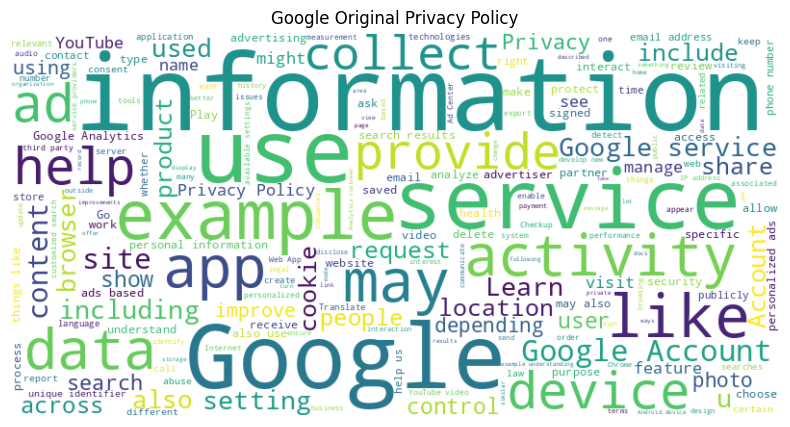

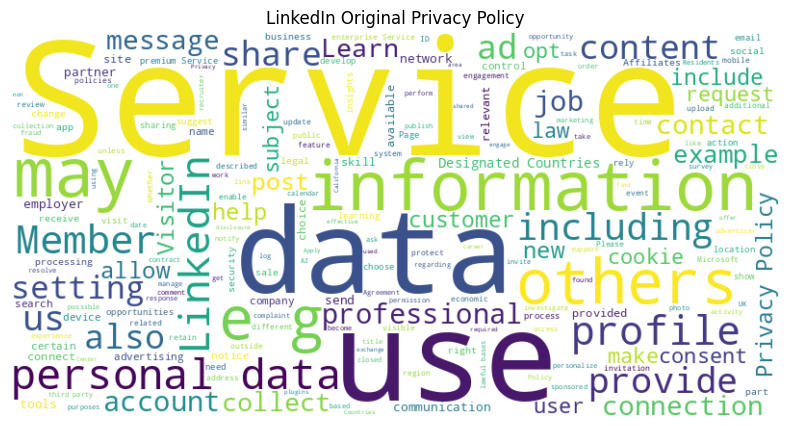

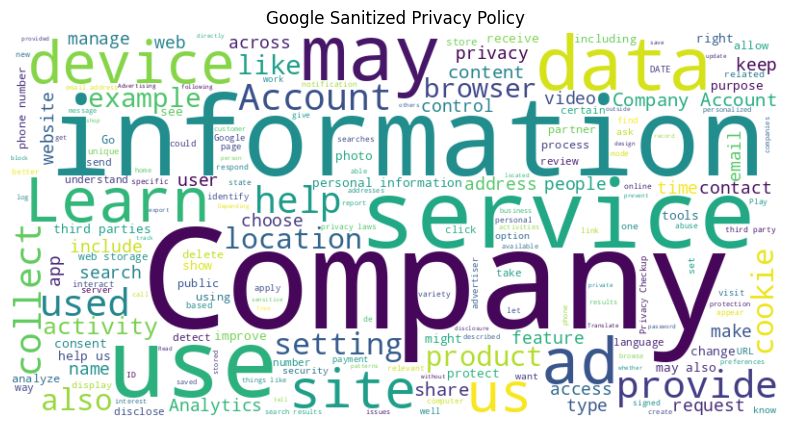

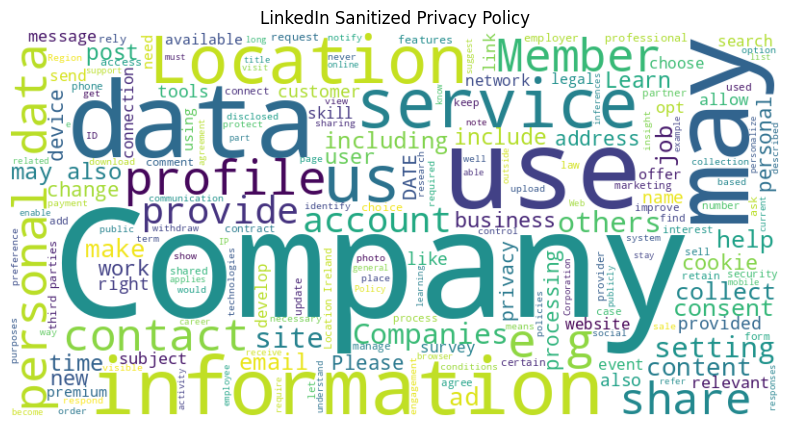

In [ ]:
# Visualization: Word Clouds for Original and Sanitized Policies
for name, text in original_policies.items():
    generate_wordcloud(text, f"{name} Original Privacy Policy")
for name, text in sanitized_policies.items():
    generate_wordcloud(text, f"{name} Sanitized Privacy Policy")

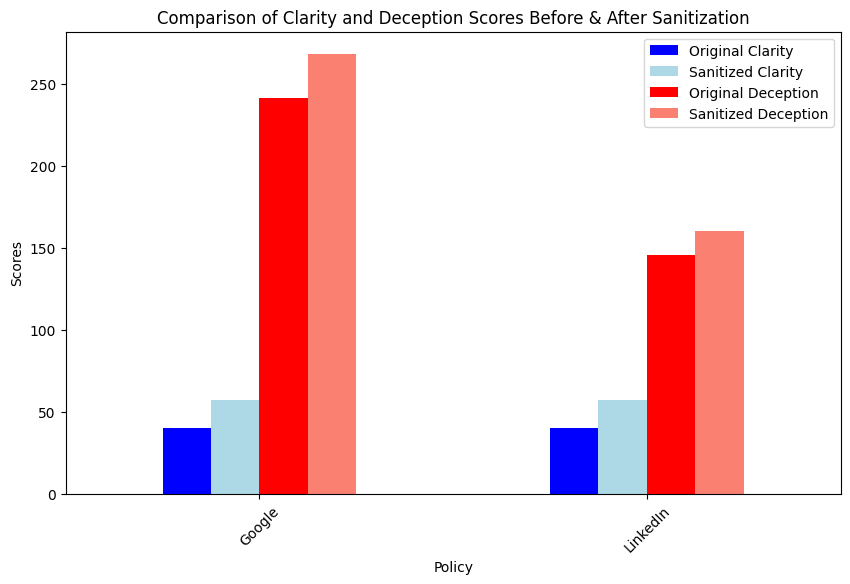

In [ ]:
# Visualization: Bar Charts
scores_df.set_index("Policy")[[
    "Original Clarity", "Sanitized Clarity",
    "Original Deception", "Sanitized Deception"
]].plot(kind='bar', figsize=(10, 6), color=['blue', 'lightblue', 'red', 'salmon'])
plt.ylabel("Scores")
plt.title("Comparison of Clarity and Deception Scores Before & After Sanitization")
plt.xticks(rotation=45)
plt.show()

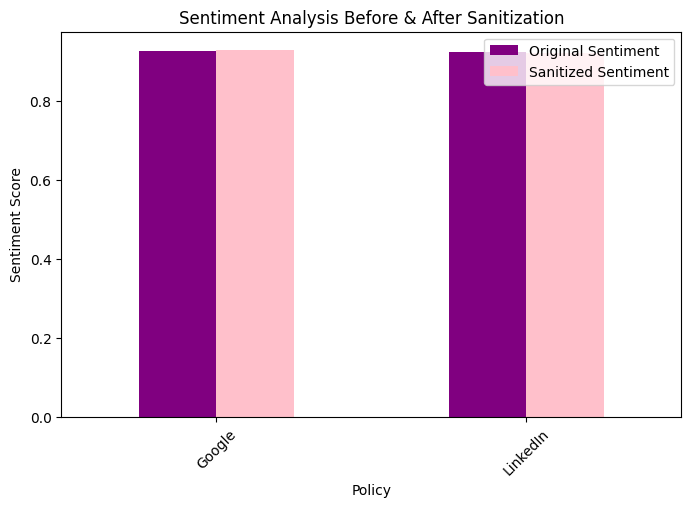

In [ ]:
# Visualization: Sentiment Analysis
scores_df.set_index("Policy")[[
    "Original Sentiment", "Sanitized Sentiment"
]].plot(kind='bar', figsize=(8, 5), color=['purple', 'pink'])
plt.ylabel("Sentiment Score")
plt.title("Sentiment Analysis Before & After Sanitization")
plt.xticks(rotation=45)
plt.show()